<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Regression-Classification/blob/master/assignment_regression_classification_4a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Installs
%%capture
!pip install --upgrade category_encoders plotly

In [419]:
# Imports
import os, sys

os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
!git pull origin master
    
os.chdir('module4')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Disable warning
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

### Load Data

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

### Train/Validate/Test Split

In [422]:
# Load initial train features and labels
from sklearn.model_selection import train_test_split
X_train = train_features
y_train = train_labels['status_group']

X_train.shape, y_train.shape

((59400, 40), (59400,))

In [423]:
# Split the initial train features and labels 80% into new train and new validation
X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, train_size = 0.80, test_size = 0.20,
  stratify = y_train, random_state=42
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 40), (11880, 40), (47520,), (11880,))

In [424]:
# Check values of new train labels
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [425]:
# Check values of new validation labels
y_val.value_counts(normalize=True)

functional                 0.543098
non functional             0.384259
functional needs repair    0.072643
Name: status_group, dtype: float64

### One-Hot Encoding - Quantity

In [426]:
# Check values of quantity feature
X_train['quantity'].value_counts(normalize=True)

enough          0.559070
insufficient    0.255745
dry             0.103556
seasonal        0.068266
unknown         0.013363
Name: quantity, dtype: float64

In [427]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train

train.groupby('quantity')['status_group'].value_counts(normalize=True)

quantity      status_group           
dry           non functional             0.967689
              functional                 0.026011
              functional needs repair    0.006300
enough        functional                 0.650920
              non functional             0.276998
              functional needs repair    0.072082
insufficient  functional                 0.521106
              non functional             0.382786
              functional needs repair    0.096108
seasonal      functional                 0.580456
              non functional             0.318434
              functional needs repair    0.101110
unknown       non functional             0.713386
              functional                 0.267717
              functional needs repair    0.018898
Name: status_group, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Water Quantity')

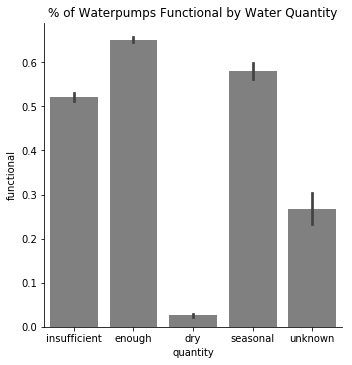

In [428]:
# Plot the values, dry shows a strong relationship to functional
import matplotlib.pyplot as plt
import seaborn as sns

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='quantity', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Water Quantity')

### One-Hot Encoding - Waterpoint Type

In [429]:
X_train['waterpoint_type'].value_counts(normalize=True)

communal standpipe             0.479335
hand pump                      0.294928
other                          0.108123
communal standpipe multiple    0.102357
improved spring                0.013279
cattle trough                  0.001873
dam                            0.000105
Name: waterpoint_type, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Waterpoint Type')

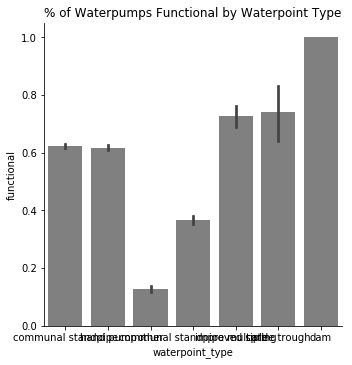

In [430]:
# Recombine X_train and y_train, for exploratory data analysis
train = X_train.copy()
train['status_group'] = y_train
train.groupby('waterpoint_type')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='waterpoint_type', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Waterpoint Type')

### One-Hot Encoding - Extraction Type

Text(0.5, 1.0, '% of Waterpumps Functional by Extraction Type')

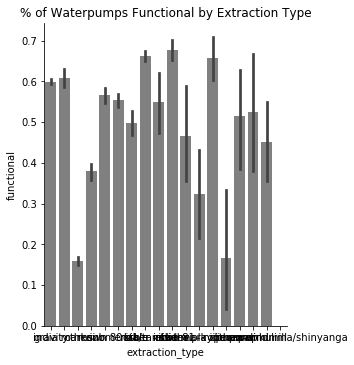

In [431]:
X_train['extraction_type'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('extraction_type')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='extraction_type', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Extraction Type')

### Bin and One-Hot Encoding - Installer

In [432]:
X_train['installer'].value_counts(normalize=True)
top10 = X_train['installer'].value_counts()[:5].index
X_train.loc[~X_train['installer'].isin(top10), 'installer'] = 'Other'
X_val.loc[~X_val['installer'].isin(top10), 'installer'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('installer')['status_group'].value_counts(normalize=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


installer   status_group           
Commu       functional                 0.685579
            non functional             0.284870
            functional needs repair    0.029551
DANIDA      functional                 0.507126
            non functional             0.419240
            functional needs repair    0.073634
DWE         functional                 0.540635
            non functional             0.366361
            functional needs repair    0.093003
Government  non functional             0.569273
            functional                 0.288066
            functional needs repair    0.142661
Other       functional                 0.563324
            non functional             0.377089
            functional needs repair    0.059587
RWE         non functional             0.639583
            functional                 0.251042
            functional needs repair    0.109375
Name: status_group, dtype: float64

Text(0.5, 1.0, '% of Waterpumps Functional by Installer')

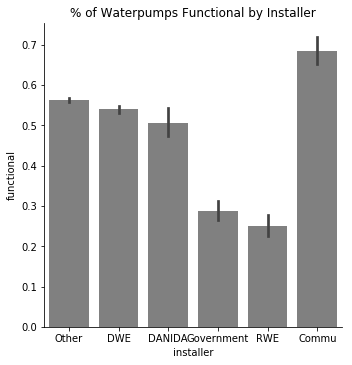

In [433]:
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='installer', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Installer')

### New Feature - Pump Age

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Text(0.5, 1.0, '% of Waterpumps Functional by Pump Age')

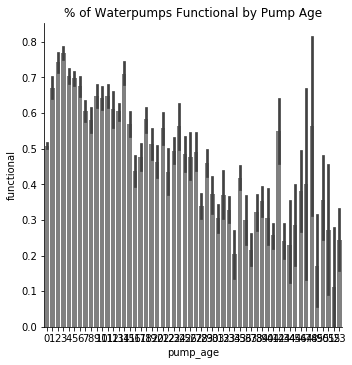

In [434]:
X_train['pump_age'] = 2013 - X_train['construction_year']
X_train.loc[X_train['pump_age'] == 2013, 'pump_age'] = 0
X_val['pump_age'] = 2013 - X_val['construction_year']
X_val.loc[X_val['pump_age'] == 2013, 'pump_age'] = 0
train = X_train.copy()
train['status_group'] = y_train

train.groupby('pump_age')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='pump_age', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Pump Age')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, '% of Waterpumps Functional by Funder')

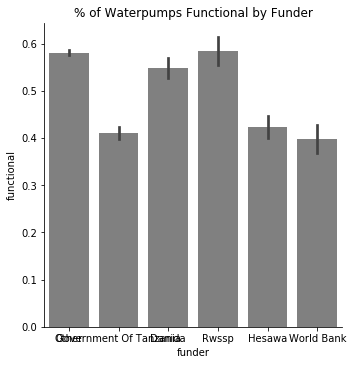

In [435]:
X_train['funder'].value_counts(normalize=True)
top10 = X_train['funder'].value_counts()[:5].index
X_train.loc[~X_train['funder'].isin(top10), 'funder'] = 'Other'
X_val.loc[~X_val['funder'].isin(top10), 'funder'] = 'Other'

train = X_train.copy()
train['status_group'] = y_train

train.groupby('funder')['status_group'].value_counts(normalize=True)

train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='funder', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Funder')

Text(0.5, 1.0, '% of Waterpumps Functional by Water Quality')

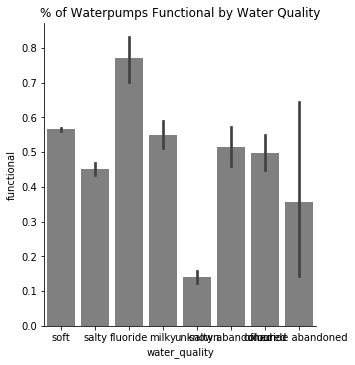

In [436]:
X_train['water_quality'].value_counts(normalize=True)
train = X_train.copy()
train['status_group'] = y_train
train.groupby('water_quality')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']]

sns.catplot(x='water_quality', y='functional', data=train, kind='bar', color='grey')
plt.title('% of Waterpumps Functional by Water Quality')

In [442]:
X_train.loc[X_train['gps_height'] == 0, 'gps_height'] = X_train['gps_height'].mean()
X_val.loc[X_val['gps_height'] == 0, 'gps_height'] = X_val['gps_height'].mean()

train = X_train.copy()
train['status_group'] = y_train

train.groupby('gps_height')['status_group'].value_counts(normalize=True)
train['functional']= (train['status_group'] == 'functional').astype(int)
train[['status_group', 'functional']];

#sns.catplot(x='amount_tsh', y='functional', data=train, kind='bar', color='grey')
#plt.title('% of Waterpumps Functional by Pump Age')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Run the Logistic Regression

In [0]:
import sklearn
sklearn.__version__

# Import the class
from sklearn.linear_model import LogisticRegressionCV

# Import package and scaler
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [439]:
# use quantity feature and the numerical features but drop id
categorical_features = ['quantity', 'waterpoint_type', 'extraction_type', 'installer']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

# make subsets using the quantity feature all numeric features except id
X_train_subset = X_train[features]
X_val_subset = X_val[features]

# Do the encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

# Use the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# Fit the model and check the accuracy
model = LogisticRegressionCV(n_jobs = -1)
model.fit(X_train_scaled, y_train)

print('Validation Accuracy', model.score(X_val_scaled, y_val));

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Validation Accuracy 0.7202020202020202


In [440]:
model.coef_

array([[ 1.70174609e-01,  4.25914353e-01, -1.02705436e+00,
         1.33545661e-01, -5.62839410e-02,  2.78089265e-01,
        -3.91801398e-02, -3.41513380e-01, -1.02365824e-01,
         1.15674422e-01,  4.22543614e-02,  9.30070477e-02,
        -4.42808460e-02,  8.41132535e-02, -2.79450929e-01,
        -6.99442760e-02,  7.44842251e-02, -1.31117919e-02,
        -8.26839896e-02,  2.59689152e-01, -3.82366192e-03,
         1.09401263e-01, -1.21720232e-02, -1.39107595e-02,
         1.98907598e-02, -5.17896662e-02, -2.57503209e-02,
         6.79114484e-03, -1.82147695e-02, -2.68561245e-02,
         1.54851977e-02,  1.97480618e-02,  1.43337315e-02,
        -1.69102934e-01, -8.75159544e-02,  1.74442232e-01,
         3.82574676e-01,  1.37527387e-01,  4.76922262e-02,
        -6.39324952e-02, -3.41732104e-03, -1.84155391e-01,
         8.48473842e-02,  4.83692793e-02,  2.38669769e-01,
        -4.72481207e-01],
       [ 4.55179780e-02, -6.03069483e-04, -7.86209557e-02,
         2.72318735e-02, -2.15

In [0]:
functional_coefficients = pd.Series(
  model.coef_[0],
  X_train_encoded.columns
)

#plt.figure(figsize=(10, 10))
#functional_coefficients.sort_values().plot.bar